In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt


# K-modes
import kmodes

# 나무
from sklearn.tree import export_graphviz
import graphviz

# 데이터 분할
from sklearn.model_selection import train_test_split

# 예측 모형: Logistic regression
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as dtC
from sklearn.ensemble import GradientBoostingClassifier as GBC

from sklearn.model_selection import GridSearchCV

# 평가 함수
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, f1_score


# https://pypi.org/project/kmodes/
from kmodes.kmodes import KModes

%matplotlib inline
matplotlib.rc('font', family = 'NanumBarunGothic')

path = '/home/pirl/BDAI-정덕성/Group/Python/'
list_files = ['user.csv', 'address.csv', 'contract.csv']

In [2]:
df = pd.read_csv(path + 'merged_final.csv', engine='python', encoding = 'euc-kr')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49645 entries, 0 to 49644
Data columns (total 23 columns):
gender              49645 non-null object
customerType        49645 non-null object
age                 49645 non-null object
marital             49645 non-null object
residence           49645 non-null object
channel             49645 non-null object
credit              49645 non-null object
payment             49645 non-null object
paymentCO           49645 non-null object
province            49645 non-null object
provinceIS          49645 non-null object
cityGrade           49645 non-null object
channelType         49645 non-null object
contractExtended    49645 non-null object
contractType        49645 non-null object
contractType_1      49645 non-null object
contractType_2      49645 non-null object
cityGradeIS         49645 non-null object
Termination_str     49645 non-null object
maxDay_str          49645 non-null object
maxGift_str         49645 non-null object
Terminati

## X & Y 분리: cityGradeIS 기준

In [12]:
df_tree = df.query('Termination_str == "중도 해약 X"')
df_tree = df_tree.query('customerType == "PERSONAL"')
df_tree['Termination_str'].unique()

array(['중도 해약 X'], dtype=object)

In [13]:
df_tree.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41529 entries, 0 to 49644
Data columns (total 23 columns):
gender              41529 non-null object
customerType        41529 non-null object
age                 41529 non-null object
marital             41529 non-null object
residence           41529 non-null object
channel             41529 non-null object
credit              41529 non-null object
payment             41529 non-null object
paymentCO           41529 non-null object
province            41529 non-null object
provinceIS          41529 non-null object
cityGrade           41529 non-null object
channelType         41529 non-null object
contractExtended    41529 non-null object
contractType        41529 non-null object
contractType_1      41529 non-null object
contractType_2      41529 non-null object
cityGradeIS         41529 non-null object
Termination_str     41529 non-null object
maxDay_str          41529 non-null object
maxGift_str         41529 non-null object
Terminati

## 품종 3종

In [14]:
df_tree_short = df_tree.drop(['customerType', # 고객/법인 따로 분석
                              'channel', 'channelType',  # channelType 사용
                              'credit', 'payment', 'paymentCO', # 경향성 없음
                              'province', 'provinceIS',
                              'cityGrade', # 실거주지 정보 제외
                              'contractExtended', # 목표변수 파생변수 제외
                              'contractType_1', 'contractType_2', # 6개 범주 사용
                              'Termination_str', 
                              'maxDay_str', 'maxGift_str', 'Termination_rate', 'overDue_str'],
                             axis=1) # 경향성 없음             
                                  
# X, Y 분리 & Dummy 변수
df_tree_y = df_tree[['contractType']]

In [15]:
df_tree_y['contractType'].unique()

array(['MMQ', 'EIQ', 'HIQ', 'MIQ', 'HMQ', 'EMQ'], dtype=object)

In [16]:
df_tree_s = pd.get_dummies(df_tree_short.drop('contractType', axis=1), drop_first = True)
df_tree_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41529 entries, 0 to 49644
Data columns (total 14 columns):
gender_MALE            41529 non-null uint8
age_30대                41529 non-null uint8
age_40대                41529 non-null uint8
age_50대                41529 non-null uint8
age_60대 이상             41529 non-null uint8
marital_SINGLE         41529 non-null uint8
residence_ETC.         41529 non-null uint8
residence_HOUSE        41529 non-null uint8
residence_OFFICETEL    41529 non-null uint8
cityGradeIS_2급지        41529 non-null uint8
cityGradeIS_3급지        41529 non-null uint8
cityGradeIS_4급지        41529 non-null uint8
cityGradeIS_5급지        41529 non-null uint8
cityGradeIS_6급지        41529 non-null uint8
dtypes: uint8(14)
memory usage: 892.2 KB


In [17]:
# 나무 데이터
df_train_s, df_test_s, df_train_y, df_test_y = train_test_split(df_tree_s, df_tree_y, test_size = 0.3)

print('train data X size:{}'.format(df_train_s.shape))
print('train data Y size:{}'.format(df_train_y.shape))
print('test data X size:{}'.format(df_test_s.shape))
print('test data Y size:{}'.format(df_test_y.shape))


train data X size:(29070, 14)
train data Y size:(29070, 1)
test data X size:(12459, 14)
test data Y size:(12459, 1)


# 랜덤포레스트

In [18]:
dt_default = DTC()
dt_default.fit(df_train_s, df_train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [19]:
y_train_pred = dt_default.predict(df_train_s)
y_test_pred = dt_default.predict(df_test_s)

# # AUC
# false_positive_rate, true_positive_rate, thresholds = roc_curve(df_train_y, y_pred)
# roc_auc_train = auc(false_positive_rate, true_positive_rate)

# false_positive_rate, true_positive_rate, thresholds = roc_curve(df_test_y, y_pred)
# roc_auc_test = auc(false_positive_rate, true_positive_rate)

# f1 score
f1_train = f1_score(df_train_y, y_train_pred, average='micro')
f1_test = f1_score(df_test_y, y_test_pred, average='micro')


# print('Accuracy on Training: {0:.3f}\n'.format(dt_default.score(df_train_s, df_train_y)))
# print('Accuracy on Test: {0:.3f}\n'.format(dt_default.score(df_test_s, df_test_y)))

# # print('AUC on Training: {0:.3f}\n'.format(roc_auc_train))
# # print('AUC on Test: {0:.3f}\n'.format(roc_auc_test))
print('F1 on Training: {0:.3f}\n'.format(f1_train))
print('F1 on Test: {0:.3f}\n'.format(f1_test))

F1 on Training: 0.621

F1 on Test: 0.613



### Parameter

In [21]:
params = {'max_depth': None,
          'max_leaf_nodes': None,
          'min_samples_leaf': None,
          'min_samples_split': None,
          'max_features': None}

### 나무의 최대 깊이

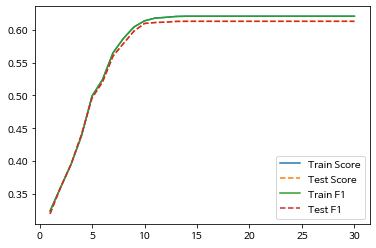

In [44]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []; train_f1 = []; test_f1 = []

# depth
para_depth = [depth for depth in range(1, 31)]


for v_depth in para_depth:
    dt = DTC(max_depth = v_depth)
    dt.fit(df_train_s, df_train_y)
    y_train_pred = dt.predict(df_train_s)
    y_test_pred = dt.predict(df_test_s)
    train_accuracy.append(dt.score(df_train_s, df_train_y))
    test_accuracy.append(dt.score(df_test_s, df_test_y))
    train_f1.append(f1_score(df_train_y, y_train_pred, average='micro'))
    test_f1.append(f1_score(df_test_y, y_test_pred, average='micro'))
    
    
df_score_depth = pd.DataFrame({'N_Tree': para_depth,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy,
                             'TrainF1': train_f1,
                             'TestF1': test_f1})

plt.plot(para_depth, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_depth, test_accuracy, linestyle='--', label="Test Score")
plt.plot(para_depth, train_f1, linestyle='-', label="Train F1")
plt.plot(para_depth, test_f1, linestyle='--', label="Test F1")
plt.legend()

In [45]:
df_score_depth.sort_values('TestF1', ascending = False)

,N_Tree,TrainScore,TestScore,TrainF1,TestF1
15,16,0.621053,0.613292,0.621053,0.613292
16,17,0.621053,0.613292,0.621053,0.613292
28,29,0.621053,0.613292,0.621053,0.613292
27,28,0.621053,0.613292,0.621053,0.613292
26,27,0.621053,0.613292,0.621053,0.613292
25,26,0.621053,0.613292,0.621053,0.613292
24,25,0.621053,0.613292,0.621053,0.613292
23,24,0.621053,0.613292,0.621053,0.613292
22,23,0.621053,0.613292,0.621053,0.613292
21,22,0.621053,0.613292,0.621053,0.613292


In [46]:
params['max_depth'] = 16

### 최소 분리 노드 크기

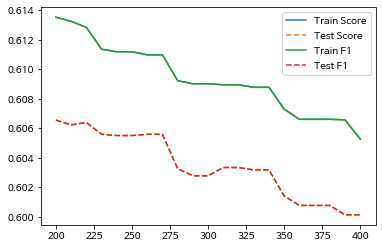

In [47]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []; train_f1 = []; test_f1 = []

# split
para_split = [split*10 for split in range(20, 41)]


for v_split in para_split:
    dt = DTC(max_depth = params['max_depth'],
             min_samples_split = v_split)
    dt.fit(df_train_s, df_train_y)
    y_train_pred = dt.predict(df_train_s)
    y_test_pred = dt.predict(df_test_s)
    train_accuracy.append(dt.score(df_train_s, df_train_y))
    test_accuracy.append(dt.score(df_test_s, df_test_y))
    train_f1.append(f1_score(df_train_y, y_train_pred, average='micro'))
    test_f1.append(f1_score(df_test_y, y_test_pred, average='micro'))
    
    
df_score_split = pd.DataFrame({'split': para_split,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy,
                             'TrainF1': train_f1,
                             'TestF1': test_f1})

plt.plot(para_split, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_split, test_accuracy, linestyle='--', label="Test Score")
plt.plot(para_split, train_f1, linestyle='-', label="Train F1")
plt.plot(para_split, test_f1, linestyle='--', label="Test F1")
plt.legend()

In [48]:
df_score_split.sort_values('TestF1', ascending = False)

,split,TrainScore,TestScore,TrainF1,TestF1
0,200,0.613519,0.606549,0.613519,0.606549
2,220,0.612831,0.606389,0.612831,0.606389
1,210,0.613244,0.606228,0.613244,0.606228
3,230,0.611352,0.605586,0.611352,0.605586
6,260,0.610974,0.605586,0.610974,0.605586
7,270,0.610974,0.605586,0.610974,0.605586
4,240,0.611180,0.605506,0.611180,0.605506
5,250,0.611180,0.605506,0.611180,0.605506
11,310,0.608944,0.603339,0.608944,0.603339
12,320,0.608944,0.603339,0.608944,0.603339


In [50]:
params['min_samples_split'] = 200

### 최소 최종노드 크기

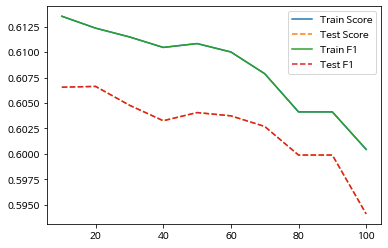

In [51]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []; train_f1 = []; test_f1 = []

# leaf
para_leaf = [leaf*10 for leaf in range(1, 11)]


for v_leaf in para_leaf:
    dt = DTC(max_depth = params['max_depth'],
             min_samples_split = params['min_samples_split'],
             min_samples_leaf = v_leaf)
    dt.fit(df_train_s, df_train_y)
    y_train_pred = dt.predict(df_train_s)
    y_test_pred = dt.predict(df_test_s)
    train_accuracy.append(dt.score(df_train_s, df_train_y))
    test_accuracy.append(dt.score(df_test_s, df_test_y))
    train_f1.append(f1_score(df_train_y, y_train_pred, average='micro'))
    test_f1.append(f1_score(df_test_y, y_test_pred, average='micro'))
    
    
df_score_leaf = pd.DataFrame({'leaf': para_leaf,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy,
                             'TrainF1': train_f1,
                             'TestF1': test_f1})

plt.plot(para_leaf, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_leaf, test_accuracy, linestyle='--', label="Test Score")
plt.plot(para_leaf, train_f1, linestyle='-', label="Train F1")
plt.plot(para_leaf, test_f1, linestyle='--', label="Test F1")
plt.legend()

In [52]:
df_score_leaf.sort_values('TestF1', ascending = False)

,leaf,TrainScore,TestScore,TrainF1,TestF1
1,20,0.612350,0.606630,0.612350,0.606630
0,10,0.613519,0.606549,0.613519,0.606549
2,30,0.611490,0.604784,0.611490,0.604784
4,50,0.610836,0.604061,0.610836,0.604061
5,60,0.610010,0.603740,0.610010,0.603740
3,40,0.610458,0.603259,0.610458,0.603259
6,70,0.607878,0.602697,0.607878,0.602697
7,80,0.604128,0.599888,0.604128,0.599888
8,90,0.604128,0.599888,0.604128,0.599888
9,100,0.600447,0.594109,0.600447,0.594109


In [53]:
params['min_samples_leaf'] = 100

### 최대 사용 변수

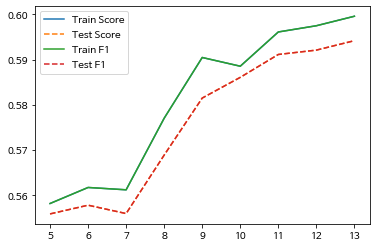

In [54]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []; train_f1 = []; test_f1 = []

# feature
para_feature = [feature for feature in range(5, len(df_train_s.columns))]


for v_feature in para_feature:
    dt = DTC(max_depth = params['max_depth'],
             min_samples_leaf = params['min_samples_leaf'],
             min_samples_split = params['min_samples_split'],
             max_features = v_feature)
    dt.fit(df_train_s, df_train_y)
    y_train_pred = dt.predict(df_train_s)
    y_test_pred = dt.predict(df_test_s)
    train_accuracy.append(dt.score(df_train_s, df_train_y))
    test_accuracy.append(dt.score(df_test_s, df_test_y))
    train_f1.append(f1_score(df_train_y, y_train_pred, average='micro'))
    test_f1.append(f1_score(df_test_y, y_test_pred, average='micro'))
    
    
df_score_feature = pd.DataFrame({'feature': para_feature,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy,
                             'TrainF1': train_f1,
                             'TestF1': test_f1})

plt.plot(para_feature, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_feature, test_accuracy, linestyle='--', label="Test Score")
plt.plot(para_feature, train_f1, linestyle='-', label="Train F1")
plt.plot(para_feature, test_f1, linestyle='--', label="Test F1")
plt.legend()

In [55]:
df_score_feature.sort_values('TestF1', ascending = False)

,feature,TrainScore,TestScore,TrainF1,TestF1
8,13,0.599587,0.594189,0.599587,0.594189
7,12,0.597489,0.592102,0.597489,0.592102
6,11,0.596113,0.591139,0.596113,0.591139
5,10,0.588545,0.586082,0.588545,0.586082
4,9,0.590471,0.581507,0.590471,0.581507
3,8,0.577055,0.568906,0.577055,0.568906
1,6,0.561748,0.557830,0.561748,0.557830
2,7,0.561232,0.555984,0.561232,0.555984
0,5,0.558204,0.555903,0.558204,0.555903


In [56]:
params['max_features'] = 13

### 최종 모형

In [64]:
dt_final = DTC(max_depth = 6,
             min_samples_leaf = params['min_samples_leaf'],
             min_samples_split = params['min_samples_split'],
             max_features = params['max_features'])
dt_final.fit(df_train_s, df_train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=13, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=200,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [65]:
y_pred = dt_final.predict(df_test_s)

# f1 score
f1Score = f1_score(df_test_y, y_pred, average = 'micro')

print('F1: {0:.3f}\n'.format(f1Score))
print('Accuracy: {0:.3f}\n'.format(accuracy_score(df_test_y, y_pred)))
print('Confusion Mat:\n{}'.format(confusion_matrix(df_test_y, y_pred)))

F1: 0.523

Accuracy: 0.523

Confusion Mat:
[[ 892  363   29    0  211  156]
 [ 506 1047   23    0   74  304]
 [ 104   94  573  117  169  167]
 [ 185   55  260  525   80  251]
 [ 206   72  176    2 1744 1192]
 [ 213   78  114   18  721 1738]]


In [66]:
df_importance = pd.DataFrame()
v_feature_name = df_train_s.columns
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = dt_final.feature_importances_ # TREECLASS.feature_importances_

df_importance.sort_values('Importance', ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
9,cityGradeIS_2급지,0.244
0,gender_MALE,0.231
5,marital_SINGLE,0.115
10,cityGradeIS_3급지,0.094
2,age_40대,0.092
11,cityGradeIS_4급지,0.061
1,age_30대,0.060
12,cityGradeIS_5급지,0.031
7,residence_HOUSE,0.030
8,residence_OFFICETEL,0.028


Text(0, 0.5, '변수')

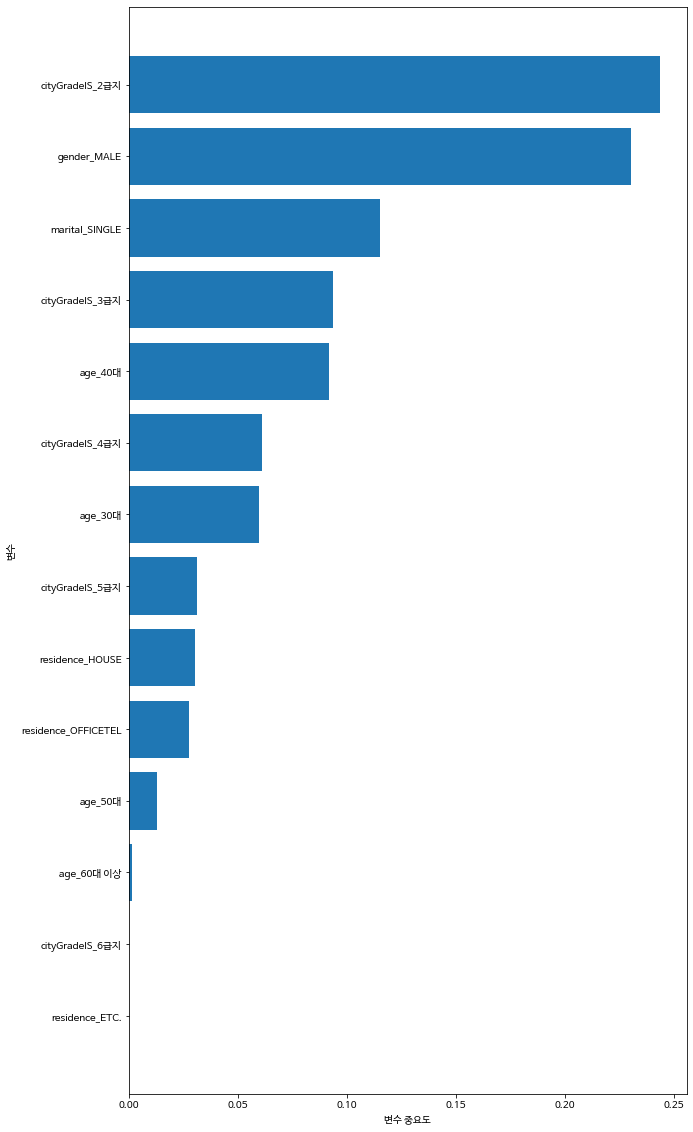

In [67]:
df_importance.sort_values('Importance', ascending=True, inplace=True)
coordinates=range(len(df_importance))
plt.figure(figsize=(10,20))

plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

# 나무 그림

In [68]:
export_graphviz(dt_final, out_file='tree_leaf.dot',
               feature_names=v_feature_name, impurity=True, filled=True)
with open('tree_leaf.dot') as f:
    dot_graph = f.read()

graphviz.Source(dot_graph).view()

'Source.gv.pdf'